In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import t as t_dist
from statsmodels.tsa.base.datetools import dates_from_str


# 1 - Bivariate

In [2]:
### First - Read the data
data = pd.read_csv('Simple_Data_2.csv',index_col=0)
nlag = 1


data.iloc[:,0] = np.log(data.iloc[:,0]).diff().multiply(100)
# data.iloc[:,1] = data.iloc[:,1].diff().multiply(1)


data = data.dropna()

In [3]:
def VARmakexy(DATA, lags, const):
    nobs, _ = DATA.shape
    Y = DATA[lags:].to_numpy()

    if const == 0:
        X = np.hstack([DATA[i:nobs - lags + i] for i in range(lags)])
    elif const == 1:
        X = np.hstack([DATA[i:nobs - lags + i] for i in range(lags)])
        X = np.hstack([np.ones((nobs - lags, 1)), X])
    elif const == 2:
        X = np.hstack([DATA[i:nobs - lags + i] for i in range(lags)])
        trend = np.arange(1, nobs - lags + 1)
        X = np.hstack([np.ones((nobs - lags, 1)), trend.reshape(-1, 1), X])
    elif const == 3:
        X = np.hstack([DATA[i:nobs - lags + i] for i in range(lags)])
        trend = np.arange(1, nobs - lags + 1)
        X = np.hstack([np.ones((nobs - lags, 1)), trend.reshape(-1, 1), (trend ** 2).reshape(-1, 1), X])
    else:
        raise ValueError('const should be 0, 1, 2, or 3')

    return Y, X

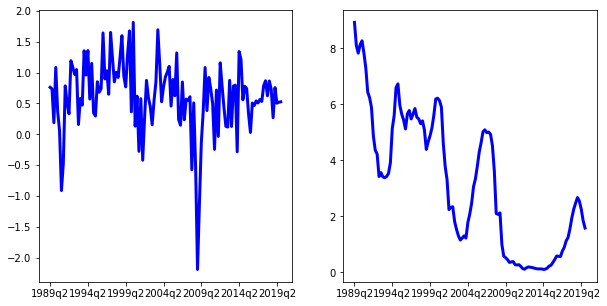

In [4]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(1,2,figsize = (10,5))
for i in range(2):
    data.iloc[:,i].plot(ax=axes[i],lw=3,color='b')

In [16]:
# def VARmodel(ENDO, nlag, const=0, EXOG=None, nlag_ex=0):


## Check Inputs
# ENDO = np.log(data).diff().dropna().copy()
ENDO = data.copy()
nlag = 1
const = 1


nlag_ex = 0
EXOG = None

nobs, nvar = ENDO.shape


## Initialize VAR
VARopt = {'const': const, 'nlag': nlag, 'nlag_ex': nlag_ex}
VAR = {'ENDO': ENDO, 'nlag': nlag, 'const': const}

## TODO: Implement exogenous Later
if EXOG is not None:
    nobs_ex, nvar_ex = EXOG.shape
    if nobs_ex != nobs:
        raise ValueError('nobs in EXOG-matrix not the same as y-matrix')
    VAR['EXOG'] = EXOG
else:
    nvar_ex = 0
    VAR['EXOG'] = None



## Save some parameters and create data matrices
nobse = nobs - max(nlag, nlag_ex)
VAR.update({
    'nobs': nobse,
    'nvar': nvar,
    'nvar_ex': nvar_ex,
    'nlag': nlag,
    'nlag_ex': nlag_ex,
    'ncoeff': nvar * nlag,
    'ntotcoeff': nvar * nlag + nvar_ex * (nlag_ex + 1) + const
})

## Create independent vector and lagged dependent matrix
Y, X = VARmakexy(ENDO, nlag, const)

# Create (lagged) exogenous matrix
## TODO: Implement exogenous Later
# if nvar_ex > 0:
#     X_EX = VARmakelags(EXOG, nlag_ex)
#     if nlag == nlag_ex:
#         X = np.hstack([X, X_EX])
#     elif nlag > nlag_ex:
#         diff = nlag - nlag_ex
#         X_EX = X_EX[diff:, :]
#         X = np.hstack([X, X_EX])
#     elif nlag < nlag_ex:
#         diff = nlag_ex - nlag
#         Y = Y[diff:, :]
#         X = np.hstack([X[diff:, :], X_EX])

# OLS estimation equation by equation
VAR['results'] = {}
for j in range(nvar):
    Yvec = Y[:, j]
    model = sm.OLS(Yvec, X).fit()
    VAR['results'][f'eq{j+1}'] = {
        'beta': model.params,
        'tstat': model.tvalues,
        'bstd': model.bse,
        'tprob': model.pvalues,
        'resid': model.resid,
        'yhat': model.fittedvalues,
        'y': Yvec,
        'rsqr': model.rsquared,
        'rbar': model.rsquared_adj,
        'sige': model.scale,
    }


# Compute the matrix of coefficients & VCV
Ft = np.linalg.inv(X.T @ X) @ X.T @ Y
VAR['Ft'] = Ft
F = Ft.T
SIGMA = (1 / (nobse - VAR['ntotcoeff'])) * ((Y - X @ Ft).T @ (Y - X @ Ft))
VAR.update({
    'F': Ft.T,
    'sigma': SIGMA,
    'resid': Y - X @ Ft,
    'X': X,
    'Y': Y
})

## TODO: Implement exogenous Later
# if nvar_ex > 0:
#     VAR['X_EX'] = X_EX


# Companion matrix of F and max eigenvalue
Fcomp = np.vstack([
    F[:, const:nvar * nlag + const], 
    np.hstack([np.eye(nvar * (nlag - 1)), np.zeros((nvar * (nlag - 1), nvar))])
])
VAR['Fcomp'] = Fcomp
VAR['maxEig'] = np.max(np.abs(np.linalg.eigvals(Fcomp)))

# Initialize other results
VAR.update({
    'B': None,   # Structural impact matrix (need identification: see VARir/VARvd/VARhd)
    'Biv': None, # First columns of structural impact matrix (need "iv" identification: see VARir/VARvd/VARhd)
    'PSI': None, # Wold multipliers (computed only with VARir/VARvd/VARhd)
    'Fp': None,  # Recursive F by lag (useful to compute MA representation)
    'IV': None   # External instruments for identification
})


###### This section - cal IRF
# if not hasattr(VAR, 'results'):
#     raise ValueError('You need to fit the VAR model first')


## Set options some options for IRF calculation
VARopt['nsteps'] = 24
VARopt['ident'] = 'short'
# VARopt.vnames = vnames_long;
# VARopt.FigSize = [26,12];

nsteps = VARopt['nsteps']
# impact = VARopt['impact']
# shut = VARopt['shut']
# recurs = VARopt['recurs']
Fcomp = VAR['Fcomp']
nvar = VAR['nvar']
nlag = VAR['nlag']
sigma = VAR['sigma']
IR = np.full((nsteps, nvar, nvar), np.nan)




PSI = np.zeros((nvar, nvar, nsteps))
VAR['Fp'] = np.zeros((nvar, nvar, nsteps))
I = VAR['const']
for ii in range(nsteps):
    if ii < nlag:
        VAR['Fp'][:, :, ii] = VAR['F'][:, I:I + nvar]
    else:
        VAR['Fp'][:, :, ii] = np.zeros((nvar, nvar))
    I += nvar

# % Compute multipliers
# PSI(:,:,1) = eye(nvar);
# for ii=2:nsteps
#     jj=1;
#     aux = 0;
#     while jj<ii
#         aux = aux + PSI(:,:,ii-jj)*VAR.Fp(:,:,jj);
#         jj=jj+1;
#     end
#     PSI(:,:,ii) = aux;
# end
# % Update VAR with Wold multipliers
# VAR.PSI = PSI;
    
'''
1-idx
PSI 1 = EYE
PSI 2 = PSI[2-1] @ VAR[1]
PSI 3 = PSI[3-1] @ VAR[1] + PSI[3-2] @ VAR[2] 

0-dx
PSI 0 = EYE
PSI 1 = PSI[0] @ VAR[0]
PSI 2 = PSI[1] @ VAR[0] + PSI[0] @ VAR[1] 

'''

PSI[:, :, 0] = np.eye(nvar)

for ii in range(1, nsteps):
    aux = np.zeros((nvar, nvar))
    jj = 1
    while jj < ii+1:
        # print(jj-1)
        # print(ii-jj)
        aux += PSI[:, :, ii - jj] @ VAR['Fp'][:, :, jj-1]
        jj += 1
    # print(aux)
    PSI[:, :, ii] = aux

from scipy.linalg import cholesky, inv
# self.PSI = PSI
if VARopt['ident'] == 'short':
    try:
        B = cholesky(sigma, lower=False).T
    except np.linalg.LinAlgError:
        raise ValueError('VCV is not positive definite')
elif VARopt['ident'] == 'long':
    Finf_big = inv(np.eye(nvar) - Fcomp)
    Finf = Finf_big[:nvar, :nvar]
    D = cholesky(Finf @ sigma @ Finf.T).T
    B = inv(Finf) @ D
elif VARopt['ident'] == 'sign':
    if self.B is None:
        raise ValueError('You need to provide the B matrix with SR.m and/or SignRestrictions.m')
    B = self.B


shut = 0
impact = 0
recurs = 'wold'

for mm in range(nvar):
    if shut != 0:
        Fcomp[shut, :] = 0
    response = np.zeros((nvar, nsteps))
    impulse = np.zeros((nvar, 1))
    if impact == 0:
        impulse[mm, 0] = 1
    elif impact == 1:
        impulse[mm, 0] = 1 / B[mm, mm]
    else:
        raise ValueError('Impact must be either 0 or 1')
    response[:, 0] = (B @ impulse).reshape(-1)
    if shut != 0:
        response[shut, 0] = 0
    if recurs == 'wold':
        for kk in range(1, nsteps):
            response[:, kk] = PSI[:, :, kk] @ (B @ impulse).reshape(-1)
    elif recurs == 'comp':
        for kk in range(1, nsteps):
            FcompN = np.linalg.matrix_power(Fcomp, kk - 1)
            response[:, kk] = FcompN[:nvar, :nvar] @ B @ impulse
    IR[:, :, mm] = response.T



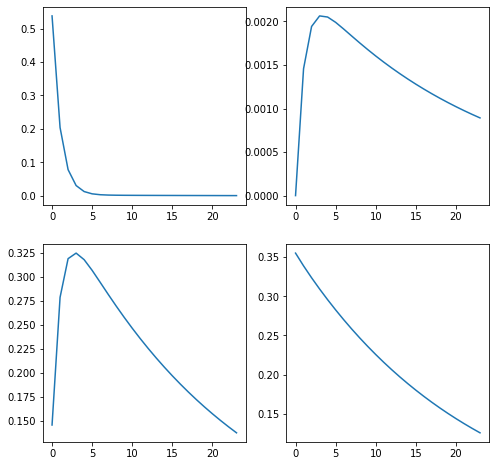

In [17]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(2,2,figsize=(8,8))
for col_i in range(2):
    for row_i in range(2):
        axes[row_i,col_i].plot(IR[:,row_i,col_i])

In [19]:


# Retrieve and initialize variables
sigma = VAR['sigma']
Fcomp = VAR['Fcomp']
const = VAR['const']
F = VAR['Ft'].T
nvar = VAR['nvar']
nvar_ex = VAR['nvar_ex']
nvarXeq = VAR['nvar'] * VAR['nlag']
nlag = VAR['nlag']
nlag_ex = VAR['nlag_ex']
Y = VAR['Y']
X = VAR['X'][:, const:nvarXeq+const]
nobs = Y.shape[0]


# Compute historical decompositions
eps = np.linalg.solve(B, VAR['resid'].T)
B_big = np.zeros((nvarXeq, nvar))
B_big[:nvar, :] = B
Icomp = np.hstack([np.eye(nvar), np.zeros((nvar, (nlag-1)*nvar))])
HDshock_big = np.zeros((nlag*nvar, nobs+1, nvar))
HDshock = np.zeros((nvar, nobs+1, nvar))
for j in range(nvar):
    eps_big = np.zeros((nvar, nobs+1))
    eps_big[j, 1:] = eps[j, :]
    for i in range(1, nobs+1):
        HDshock_big[:, i, j] = B_big @ eps_big[:, i] + Fcomp @ HDshock_big[:, i-1, j]
        HDshock[:, i, j] = Icomp @ HDshock_big[:, i, j]



# Initial value
HDinit_big = np.zeros((nlag*nvar, nobs+1))
HDinit = np.zeros((nvar, nobs+1))
HDinit_big[:, 0] = X[0, :].T
HDinit[:, 0] = Icomp @ HDinit_big[:, 0]
for i in range(1, nobs+1):
    HDinit_big[:, i] = Fcomp @ HDinit_big[:, i-1]
    HDinit[:, i] = Icomp @ HDinit_big[:, i]

# Constant
HDconst_big = np.zeros((nlag*nvar, nobs+1))
HDconst = np.zeros((nvar, nobs+1))
CC = np.zeros((nlag*nvar, 1))
if const > 0:
    CC[:nvar, :] = F[:, :1]
    for i in range(1, nobs+1):
        HDconst_big[:, i] = CC[:, 0] + Fcomp @ HDconst_big[:, i-1]
        HDconst[:, i] = Icomp @ HDconst_big[:, i]


# Linear trend
HDtrend_big = np.zeros((nlag*nvar, nobs+1))
HDtrend = np.zeros((nvar, nobs+1))
TT = np.zeros((nlag*nvar, 1))
if const > 1:
    TT[:nvar, :] = F[:, 1:2]
    for i in range(1, nobs+1):
        HDtrend_big[:, i] = TT[:, 0] * (i-1) + Fcomp @ HDtrend_big[:, i-1]
        HDtrend[:, i] = Icomp @ HDtrend_big[:, i]

# Quadratic trend
HDtrend2_big = np.zeros((nlag*nvar, nobs+1))
HDtrend2 = np.zeros((nvar, nobs+1))
TT2 = np.zeros((nlag*nvar, 1))
if const > 2:
    TT2[:nvar, :] = F[:, 2:3]
    for i in range(1, nobs+1):
        HDtrend2_big[:, i] = TT2[:, 0] * ((i-1)**2) + Fcomp @ HDtrend2_big[:, i-1]
        HDtrend2[:, i] = Icomp @ HDtrend2_big[:, i]

# Exogenous
HDexo_big = np.zeros((nlag*nvar, nobs+1))
HDexo = np.zeros((nvar, nobs+1, nvar_ex))
EXO = np.zeros((nlag*nvar, nvar_ex*(nlag_ex+1)))
if nvar_ex > 0:
    for ii in range(nvar_ex):
        VARexo = VAR['X_EX'][:, ii]
        EXO[:nvar, ii] = F[:, nvar*nlag+const+ii]
        for i in range(1, nobs+1):
            HDexo_big[:, i] = EXO[:, ii] * VARexo[i-1] + Fcomp @ HDexo_big[:, i-1]
            HDexo[:, i, ii] = Icomp @ HDexo_big[:, i]

# All decompositions must add up to the original data
HDendo = HDinit + HDconst + HDtrend + HDtrend2 + np.sum(HDexo, axis=2) + np.sum(HDshock, axis=2)


<Axes: >

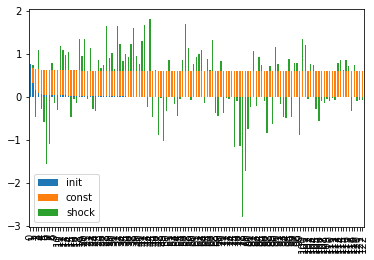

In [20]:
pd.DataFrame({'init':HDinit[0],'const':HDconst[0],'shock':np.sum(HDshock, axis=2)[0]}).plot.bar(stacked=True)

In [8]:
B

array([[0.537672  , 0.        ],
       [0.14535126, 0.35515587]])

In [114]:
## Check Inputs
# ENDO = np.log(data).diff().dropna().copy()
ENDO = data.copy()
nlag = nlag
const = 1


nlag_ex = 0
EXOG = None

nobs, nvar = ENDO.shape


## Initialize VAR
VARopt = {'const': const, 'nlag': nlag, 'nlag_ex': nlag_ex}
VAR = {'ENDO': ENDO, 'nlag': nlag, 'const': const}

## TODO: Implement exogenous Later
if EXOG is not None:
    nobs_ex, nvar_ex = EXOG.shape
    if nobs_ex != nobs:
        raise ValueError('nobs in EXOG-matrix not the same as y-matrix')
    VAR['EXOG'] = EXOG
else:
    nvar_ex = 0
    VAR['EXOG'] = None



## Save some parameters and create data matrices
nobse = nobs - max(nlag, nlag_ex)
VAR.update({
    'nobs': nobse,
    'nvar': nvar,
    'nvar_ex': nvar_ex,
    'nlag': nlag,
    'nlag_ex': nlag_ex,
    'ncoeff': nvar * nlag,
    'ntotcoeff': nvar * nlag + nvar_ex * (nlag_ex + 1) + const
})

## Create independent vector and lagged dependent matrix
Y, X = VARmakexy(ENDO, nlag, const)

VAR['results'] = {}
for j in range(nvar):
    Yvec = Y[:, j]
    model = sm.OLS(Yvec, X).fit()
    VAR['results'][f'eq{j+1}'] = {
        'beta': model.params,
        'tstat': model.tvalues,
        'bstd': model.bse,
        'tprob': model.pvalues,
        'resid': model.resid,
        'yhat': model.fittedvalues,
        'y': Yvec,
        'rsqr': model.rsquared,
        'rbar': model.rsquared_adj,
        'sige': model.scale,
    }

VAR['results'][f'eq1']['beta']

array([0.363026  , 0.37875261, 0.0041021 ])

In [120]:
# Compute the matrix of coefficients & VCV
Ft = np.linalg.inv(X.T @ X) @ X.T @ Y
VAR['Ft'] = Ft
F = Ft.T
SIGMA = (1 / (nobse - VAR['ntotcoeff'])) * ((Y - X @ Ft).T @ (Y - X @ Ft))
VAR.update({
    'F': Ft.T,
    'sigma': SIGMA,
    'resid': Y - X @ Ft,
    'X': X,
    'Y': Y
})

## TODO: Implement exogenous Later
# if nvar_ex > 0:
#     VAR['X_EX'] = X_EX


# Companion matrix of F and max eigenvalue
Fcomp = np.vstack([
    F[:, const:nvar * nlag + const], 
    np.hstack([np.eye(nvar * (nlag - 1)), np.zeros((nvar * (nlag - 1), nvar))])
])
# Fcomp = np.vstack([
#     F[:, const:nvar * nlag + const], np.eye(nvar * (nvar))
#     # np.hstack([np.eye(nvar * (nlag - 1)), np.zeros((nvar * (nlag - 1), nvar))])
# ])
VAR['Fcomp'] = Fcomp
VAR['maxEig'] = np.max(np.abs(np.linalg.eigvals(Fcomp)))

In [118]:
VAR['F']

array([[ 0.363026  ,  0.37875261,  0.0041021 ],
       [-0.07287363,  0.26072723,  0.95406355]])

In [122]:
VAR['Fcomp']

array([[0.37875261, 0.0041021 ],
       [0.26072723, 0.95406355]])

In [124]:
VAR['sigma']

array([[0.28909118, 0.0781513 ],
       [0.0781513 , 0.14726268]])

In [127]:
# def VARmodel(ENDO, nlag, const=0, EXOG=None, nlag_ex=0):


## Check Inputs
# ENDO = np.log(data).diff().dropna().copy()
ENDO = data.copy()
nlag = 1
const = 1


nlag_ex = 0
EXOG = None

nobs, nvar = ENDO.shape


## Initialize VAR
VARopt = {'const': const, 'nlag': nlag, 'nlag_ex': nlag_ex}
VAR = {'ENDO': ENDO, 'nlag': nlag, 'const': const}

## TODO: Implement exogenous Later
if EXOG is not None:
    nobs_ex, nvar_ex = EXOG.shape
    if nobs_ex != nobs:
        raise ValueError('nobs in EXOG-matrix not the same as y-matrix')
    VAR['EXOG'] = EXOG
else:
    nvar_ex = 0
    VAR['EXOG'] = None



## Save some parameters and create data matrices
nobse = nobs - max(nlag, nlag_ex)
VAR.update({
    'nobs': nobse,
    'nvar': nvar,
    'nvar_ex': nvar_ex,
    'nlag': nlag,
    'nlag_ex': nlag_ex,
    'ncoeff': nvar * nlag,
    'ntotcoeff': nvar * nlag + nvar_ex * (nlag_ex + 1) + const
})

## Create independent vector and lagged dependent matrix
Y, X = VARmakexy(ENDO, nlag, const)

# Create (lagged) exogenous matrix
## TODO: Implement exogenous Later
# if nvar_ex > 0:
#     X_EX = VARmakelags(EXOG, nlag_ex)
#     if nlag == nlag_ex:
#         X = np.hstack([X, X_EX])
#     elif nlag > nlag_ex:
#         diff = nlag - nlag_ex
#         X_EX = X_EX[diff:, :]
#         X = np.hstack([X, X_EX])
#     elif nlag < nlag_ex:
#         diff = nlag_ex - nlag
#         Y = Y[diff:, :]
#         X = np.hstack([X[diff:, :], X_EX])

# OLS estimation equation by equation
VAR['results'] = {}
for j in range(nvar):
    Yvec = Y[:, j]
    model = sm.OLS(Yvec, X).fit()
    VAR['results'][f'eq{j+1}'] = {
        'beta': model.params,
        'tstat': model.tvalues,
        'bstd': model.bse,
        'tprob': model.pvalues,
        'resid': model.resid,
        'yhat': model.fittedvalues,
        'y': Yvec,
        'rsqr': model.rsquared,
        'rbar': model.rsquared_adj,
        'sige': model.scale,
    }


# Compute the matrix of coefficients & VCV
Ft = np.linalg.inv(X.T @ X) @ X.T @ Y
VAR['Ft'] = Ft
F = Ft.T
SIGMA = (1 / (nobse - VAR['ntotcoeff'])) * ((Y - X @ Ft).T @ (Y - X @ Ft))
VAR.update({
    'F': Ft.T,
    'sigma': SIGMA,
    'resid': Y - X @ Ft,
    'X': X,
    'Y': Y
})

## TODO: Implement exogenous Later
# if nvar_ex > 0:
#     VAR['X_EX'] = X_EX


# Companion matrix of F and max eigenvalue
Fcomp = np.vstack([
    F[:, const:nvar * nlag + const], 
    np.hstack([np.eye(nvar * (nlag - 1)), np.zeros((nvar * (nlag - 1), nvar))])
])
VAR['Fcomp'] = Fcomp
VAR['maxEig'] = np.max(np.abs(np.linalg.eigvals(Fcomp)))

# Initialize other results
VAR.update({
    'B': None,   # Structural impact matrix (need identification: see VARir/VARvd/VARhd)
    'Biv': None, # First columns of structural impact matrix (need "iv" identification: see VARir/VARvd/VARhd)
    'PSI': None, # Wold multipliers (computed only with VARir/VARvd/VARhd)
    'Fp': None,  # Recursive F by lag (useful to compute MA representation)
    'IV': None   # External instruments for identification
})


###### This section - cal IRF
# if not hasattr(VAR, 'results'):
#     raise ValueError('You need to fit the VAR model first')


## Set options some options for IRF calculation
VARopt['nsteps'] = 24
VARopt['ident'] = 'long'
# VARopt.vnames = vnames_long;
# VARopt.FigSize = [26,12];

nsteps = VARopt['nsteps']
# impact = VARopt['impact']
# shut = VARopt['shut']
# recurs = VARopt['recurs']
Fcomp = VAR['Fcomp']
nvar = VAR['nvar']
nlag = VAR['nlag']
sigma = VAR['sigma']
IR = np.full((nsteps, nvar, nvar), np.nan)




PSI = np.zeros((nvar, nvar, nsteps))
VAR['Fp'] = np.zeros((nvar, nvar, nsteps))
I = VAR['const']
for ii in range(nsteps):
    if ii < nlag:
        VAR['Fp'][:, :, ii] = VAR['F'][:, I:I + nvar]
    else:
        VAR['Fp'][:, :, ii] = np.zeros((nvar, nvar))
    I += nvar

# % Compute multipliers
# PSI(:,:,1) = eye(nvar);
# for ii=2:nsteps
#     jj=1;
#     aux = 0;
#     while jj<ii
#         aux = aux + PSI(:,:,ii-jj)*VAR.Fp(:,:,jj);
#         jj=jj+1;
#     end
#     PSI(:,:,ii) = aux;
# end
# % Update VAR with Wold multipliers
# VAR.PSI = PSI;
    
'''
1-idx
PSI 1 = EYE
PSI 2 = PSI[2-1] @ VAR[1]
PSI 3 = PSI[3-1] @ VAR[1] + PSI[3-2] @ VAR[2] 

0-dx
PSI 0 = EYE
PSI 1 = PSI[0] @ VAR[0]
PSI 2 = PSI[1] @ VAR[0] + PSI[0] @ VAR[1] 

'''

PSI[:, :, 0] = np.eye(nvar)

for ii in range(1, nsteps):
    aux = np.zeros((nvar, nvar))
    jj = 1
    while jj < ii+1:
        # print(jj-1)
        # print(ii-jj)
        aux += PSI[:, :, ii - jj] @ VAR['Fp'][:, :, jj-1]
        jj += 1
    # print(aux)
    PSI[:, :, ii] = aux

from scipy.linalg import cholesky, inv
# self.PSI = PSI
if VARopt['ident'] == 'short':
    try:
        B = cholesky(sigma, lower=False).T
    except np.linalg.LinAlgError:
        raise ValueError('VCV is not positive definite')
elif VARopt['ident'] == 'long':
    Finf_big = inv(np.eye(nvar) - Fcomp)
    Finf = Finf_big[:nvar, :nvar]
    D = cholesky(Finf @ sigma @ Finf.T).T
    B = inv(Finf) @ D
elif VARopt['ident'] == 'sign':
    if self.B is None:
        raise ValueError('You need to provide the B matrix with SR.m and/or SignRestrictions.m')
    B = self.B


shut = 0
impact = 0
recurs = 'wold'

for mm in range(nvar):
    if shut != 0:
        Fcomp[shut, :] = 0
    response = np.zeros((nvar, nsteps))
    impulse = np.zeros((nvar, 1))
    if impact == 0:
        impulse[mm, 0] = 1
    elif impact == 1:
        impulse[mm, 0] = 1 / B[mm, mm]
    else:
        raise ValueError('Impact must be either 0 or 1')
    response[:, 0] = (B @ impulse).reshape(-1)
    if shut != 0:
        response[shut, 0] = 0
    if recurs == 'wold':
        for kk in range(1, nsteps):
            response[:, kk] = PSI[:, :, kk] @ (B @ impulse).reshape(-1)
    elif recurs == 'comp':
        for kk in range(1, nsteps):
            FcompN = np.linalg.matrix_power(Fcomp, kk - 1)
            response[:, kk] = FcompN[:nvar, :nvar] @ B @ impulse
    IR[:, :, mm] = response.T




In [128]:
B

array([[ 0.53678241, -0.03091642],
       [ 0.16553242,  0.34621048]])

In [106]:
## Contribution of each shock
eps = np.linalg.lstsq(B,VAR['resid'].T,rcond=None) # structural errors 
B_big = np.zeros((nvar*nlag,nvar))
B_big[0:nvar,:] = B
Icomp = np.hstack([np.eye(nvar),np.zeros((nvar,(nlag-1)*nvar))])
# Icomp = [eye(nvar) zeros(nvar,(nlag-1)*nvar)];
# HDshock_big = zeros(nlag*nvar,nobs+1,nvar);
# HDshock = zeros(nvar,nobs+1,nvar);
# for j=1:nvar % for each variable
#     eps_big = zeros(nvar,nobs+1); % matrix of shocks conformable with companion
#     eps_big(j,2:end) = eps(j,:);
#     for i = 2:nobs+1
#         HDshock_big(:,i,j) = B_big*eps_big(:,i) + Fcomp*HDshock_big(:,i-1,j);
#         HDshock(:,i,j) =  Icomp*HDshock_big(:,i,j);
#     end
# end


# Retrieve and initialize variables
sigma = VAR['sigma']
Fcomp = VAR['Fcomp']
const = VAR['const']
F = VAR['Ft'].T
nvar = VAR['nvar']
nvar_ex = VAR['nvar_ex']
nvarXeq = VAR['nvar'] * VAR['nlag']
nlag = VAR['nlag']
nlag_ex = VAR['nlag_ex']
Y = VAR['Y']
X = VAR['X'][:, const:nvarXeq+const]
nobs = Y.shape[0]


# Compute historical decompositions
eps = np.linalg.solve(B, VAR['resid'].T)
B_big = np.zeros((nvarXeq, nvar))
B_big[:nvar, :] = B
Icomp = np.hstack([np.eye(nvar), np.zeros((nvar, (nlag-1)*nvar))])
HDshock_big = np.zeros((nlag*nvar, nobs+1, nvar))
HDshock = np.zeros((nvar, nobs+1, nvar))
for j in range(nvar):
    eps_big = np.zeros((nvar, nobs+1))
    eps_big[j, 1:] = eps[j, :]
    for i in range(1, nobs+1):
        HDshock_big[:, i, j] = B_big @ eps_big[:, i] + Fcomp @ HDshock_big[:, i-1, j]
        HDshock[:, i, j] = Icomp @ HDshock_big[:, i, j]



# Initial value
HDinit_big = np.zeros((nlag*nvar, nobs+1))
HDinit = np.zeros((nvar, nobs+1))
HDinit_big[:, 0] = X[0, :].T
HDinit[:, 0] = Icomp @ HDinit_big[:, 0]
for i in range(1, nobs+1):
    HDinit_big[:, i] = Fcomp @ HDinit_big[:, i-1]
    HDinit[:, i] = Icomp @ HDinit_big[:, i]

# Constant
HDconst_big = np.zeros((nlag*nvar, nobs+1))
HDconst = np.zeros((nvar, nobs+1))
CC = np.zeros((nlag*nvar, 1))
if const > 0:
    CC[:nvar, :] = F[:, :1]
    for i in range(1, nobs+1):
        HDconst_big[:, i] = CC[:, 0] + Fcomp @ HDconst_big[:, i-1]
        HDconst[:, i] = Icomp @ HDconst_big[:, i]


# Linear trend
HDtrend_big = np.zeros((nlag*nvar, nobs+1))
HDtrend = np.zeros((nvar, nobs+1))
TT = np.zeros((nlag*nvar, 1))
if const > 1:
    TT[:nvar, :] = F[:, 1:2]
    for i in range(1, nobs+1):
        HDtrend_big[:, i] = TT[:, 0] * (i-1) + Fcomp @ HDtrend_big[:, i-1]
        HDtrend[:, i] = Icomp @ HDtrend_big[:, i]

# Quadratic trend
HDtrend2_big = np.zeros((nlag*nvar, nobs+1))
HDtrend2 = np.zeros((nvar, nobs+1))
TT2 = np.zeros((nlag*nvar, 1))
if const > 2:
    TT2[:nvar, :] = F[:, 2:3]
    for i in range(1, nobs+1):
        HDtrend2_big[:, i] = TT2[:, 0] * ((i-1)**2) + Fcomp @ HDtrend2_big[:, i-1]
        HDtrend2[:, i] = Icomp @ HDtrend2_big[:, i]

# Exogenous
HDexo_big = np.zeros((nlag*nvar, nobs+1))
HDexo = np.zeros((nvar, nobs+1, nvar_ex))
EXO = np.zeros((nlag*nvar, nvar_ex*(nlag_ex+1)))
if nvar_ex > 0:
    for ii in range(nvar_ex):
        VARexo = VAR['X_EX'][:, ii]
        EXO[:nvar, ii] = F[:, nvar*nlag+const+ii]
        for i in range(1, nobs+1):
            HDexo_big[:, i] = EXO[:, ii] * VARexo[i-1] + Fcomp @ HDexo_big[:, i-1]
            HDexo[:, i, ii] = Icomp @ HDexo_big[:, i]

# All decompositions must add up to the original data
HDendo = HDinit + HDconst + HDtrend + HDtrend2 + np.sum(HDexo, axis=2) + np.sum(HDshock, axis=2)


<Axes: >

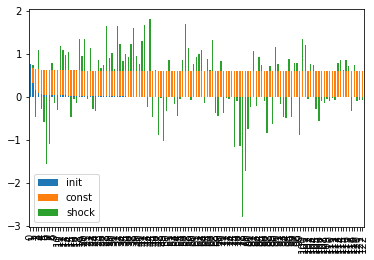

In [107]:
pd.DataFrame({'init':HDinit[0],'const':HDconst[0],'shock':np.sum(HDshock, axis=2)[0]}).plot.bar(stacked=True)

<Axes: >

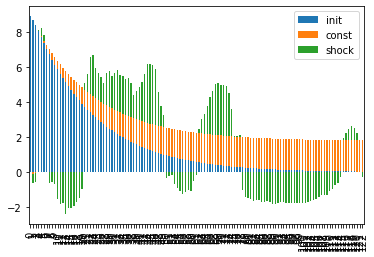

In [109]:
pd.DataFrame({'init':HDinit[1],'const':HDconst[1],'shock':np.sum(HDshock, axis=2)[1]}).plot.bar(stacked=True)

<Axes: >

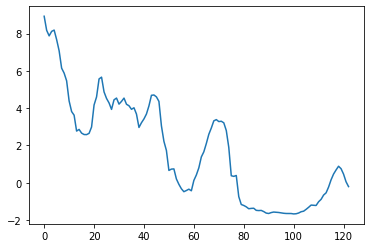

In [108]:
pd.DataFrame({'init':HDinit[1],'shock':np.sum(HDshock, axis=2)[1]}).sum(axis=1).plot()

In [88]:
pd.DataFrame(HDendo).T#.iloc[:,0].plot()

,0,1
0,0.761908,-0.36
1,0.737313,-0.83
2,0.188182,-0.27
3,1.084528,0.30
4,0.371265,0.14
...,...,...
118,0.269054,0.20
119,0.756880,-0.13
120,0.504473,-0.29
121,0.520145,-0.41


In [33]:
Y

array([[ 0.7373131 ,  8.1       ],
       [ 0.18818222,  7.83      ],
       [ 1.08452821,  8.13      ],
       [ 0.37126458,  8.27      ],
       [ 0.05557099,  7.83      ],
       [-0.91154942,  7.3       ],
       [-0.46829719,  6.44      ],
       [ 0.78549123,  6.24      ],
       [ 0.5017199 ,  5.89      ],
       [ 0.33308691,  4.87      ],
       [ 1.1936603 ,  4.36      ],
       [ 1.08933539,  4.22      ],
       [ 0.97035802,  3.42      ],
       [ 1.04955157,  3.56      ],
       [ 0.15913716,  3.41      ],
       [ 0.58134578,  3.38      ],
       [ 0.47314554,  3.42      ],
       [ 1.35442251,  3.53      ],
       [ 0.96121578,  3.91      ],
       [ 1.35733336,  5.13      ],
       [ 0.5713341 ,  5.6       ],
       [ 1.14953369,  6.6       ],
       [ 0.34725128,  6.73      ],
       [ 0.29668721,  5.97      ],
       [ 0.85218477,  5.65      ],
       [ 0.68304055,  5.44      ],
       [ 0.74277751,  5.12      ],
       [ 1.64343547,  5.66      ],
       [ 0.89799737,

<Axes: >

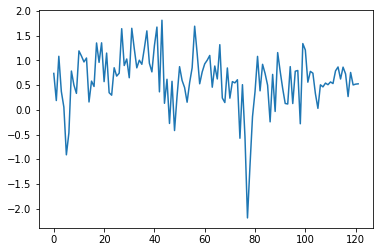

In [29]:
pd.DataFrame(Y).iloc[:,0].plot()

<Axes: >

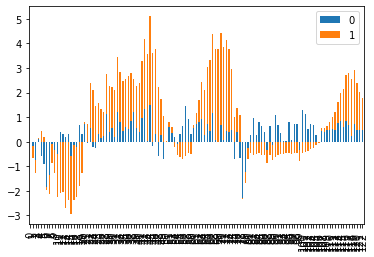

In [28]:
pd.DataFrame(np.sum(HDshock,2)).T.plot.bar(stacked=True)

In [261]:
import numpy as np

def VARhd(VAR, VARopt):
    # Check inputs
    if VAR is None:
        raise ValueError('You need to provide VAR structure, result of VARmodel')
    IV = VAR.get('IV', None)
    
    if VARopt['ident'] == 'iv':
        print('---------------------------------------------')
        print('Historical decomposition not available with')
        print('external instruments identification (iv)')
        print('---------------------------------------------')
        raise ValueError('ERROR. See details above')

    # Retrieve and initialize variables
    sigma = VAR['sigma']
    Fcomp = VAR['Fcomp']
    const = VAR['const']
    F = VAR['Ft'].T
    nvar = VAR['nvar']
    nvar_ex = VAR['nvar_ex']
    nvarXeq = VAR['nvar'] * VAR['nlag']
    nlag = VAR['nlag']
    nlag_ex = VAR['nlag_ex']
    Y = VAR['Y']
    X = VAR['X'][:, const:nvarXeq+const]
    nobs = Y.shape[0]

    # Identification: Recover B matrix
    if VARopt['ident'] == 'short':
        try:
            B = np.linalg.cholesky(sigma).T
        except np.linalg.LinAlgError:
            raise ValueError('VCV is not positive definite')
    elif VARopt['ident'] == 'long':
        Finf_big = np.linalg.inv(np.eye(len(Fcomp)) - Fcomp)
        Finf = Finf_big[:nvar, :nvar]
        D = np.linalg.cholesky(Finf @ sigma @ Finf.T).T
        B = np.linalg.solve(Finf, D)
    elif VARopt['ident'] == 'sign':
        if 'B' not in VAR:
            raise ValueError('You need to provide the B matrix with SR.m and/or SignRestrictions.m')
        else:
            B = VAR['B']
    else:
        print('---------------------------------------------')
        print('Identification incorrectly specified.')
        print('Choose one of the following options:')
        print('- short: zero contemporaneous restrictions')
        print('- long:  zero long-run restrictions')
        print('- sign:  sign restrictions')
        print('- iv:    external instrument')
        print('---------------------------------------------')
        raise ValueError('ERROR. See details above')

    # Compute historical decompositions
    eps = np.linalg.solve(B, VAR['resid'].T)
    B_big = np.zeros((nvarXeq, nvar))
    B_big[:nvar, :] = B
    Icomp = np.hstack([np.eye(nvar), np.zeros((nvar, (nlag-1)*nvar))])
    HDshock_big = np.zeros((nlag*nvar, nobs+1, nvar))
    HDshock = np.zeros((nvar, nobs+1, nvar))
    for j in range(nvar):
        eps_big = np.zeros((nvar, nobs+1))
        eps_big[j, 1:] = eps[j, :]
        for i in range(1, nobs+1):
            HDshock_big[:, i, j] = B_big @ eps_big[:, i] + Fcomp @ HDshock_big[:, i-1, j]
            HDshock[:, i, j] = Icomp @ HDshock_big[:, i, j]

    # Initial value
    HDinit_big = np.zeros((nlag*nvar, nobs+1))
    HDinit = np.zeros((nvar, nobs+1))
    HDinit_big[:, 0] = X[0, :].T
    HDinit[:, 0] = Icomp @ HDinit_big[:, 0]
    for i in range(1, nobs+1):
        HDinit_big[:, i] = Fcomp @ HDinit_big[:, i-1]
        HDinit[:, i] = Icomp @ HDinit_big[:, i]

    # Constant
    HDconst_big = np.zeros((nlag*nvar, nobs+1))
    HDconst = np.zeros((nvar, nobs+1))
    CC = np.zeros((nlag*nvar, 1))
    if const > 0:
        CC[:nvar, :] = F[:, :1]
        for i in range(1, nobs+1):
            HDconst_big[:, i] = CC[:, 0] + Fcomp @ HDconst_big[:, i-1]
            HDconst[:, i] = Icomp @ HDconst_big[:, i]

    # Linear trend
    HDtrend_big = np.zeros((nlag*nvar, nobs+1))
    HDtrend = np.zeros((nvar, nobs+1))
    TT = np.zeros((nlag*nvar, 1))
    if const > 1:
        TT[:nvar, :] = F[:, 1:2]
        for i in range(1, nobs+1):
            HDtrend_big[:, i] = TT[:, 0] * (i-1) + Fcomp @ HDtrend_big[:, i-1]
            HDtrend[:, i] = Icomp @ HDtrend_big[:, i]

    # Quadratic trend
    HDtrend2_big = np.zeros((nlag*nvar, nobs+1))
    HDtrend2 = np.zeros((nvar, nobs+1))
    TT2 = np.zeros((nlag*nvar, 1))
    if const > 2:
        TT2[:nvar, :] = F[:, 2:3]
        for i in range(1, nobs+1):
            HDtrend2_big[:, i] = TT2[:, 0] * ((i-1)**2) + Fcomp @ HDtrend2_big[:, i-1]
            HDtrend2[:, i] = Icomp @ HDtrend2_big[:, i]

    # Exogenous
    HDexo_big = np.zeros((nlag*nvar, nobs+1))
    HDexo = np.zeros((nvar, nobs+1, nvar_ex))
    EXO = np.zeros((nlag*nvar, nvar_ex*(nlag_ex+1)))
    if nvar_ex > 0:
        for ii in range(nvar_ex):
            VARexo = VAR['X_EX'][:, ii]
            EXO[:nvar, ii] = F[:, nvar*nlag+const+ii]
            for i in range(1, nobs+1):
                HDexo_big[:, i] = EXO[:, ii] * VARexo[i-1] + Fcomp @ HDexo_big[:, i-1]
                HDexo[:, i, ii] = Icomp @ HDexo_big[:, i]

    # All decompositions must add up to the original data
    HDendo = HDinit + HDconst + HDtrend + HDtrend2 + np.sum(HDexo, axis=2) + np.sum(HDshock, axis=2)
    
    # Return the historical decomposition and the VAR
    HD = {
        'HDshock': HDshock,
        'HDinit': HDinit,
        'HDconst': HDconst,
        'HDtrend': HDtrend,
        'HDtrend2': HDtrend2,
        'HDexo': HDexo,
        'HDendo': HDendo
    }
    
    return HD, VAR


array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
# % Contribution of each shock
# eps = B\transpose(VAR.resid); % structural errors 
# B_big = zeros(nvarXeq,nvar);
# B_big(1:nvar,:) = B;
# Icomp = [eye(nvar) zeros(nvar,(nlag-1)*nvar)];
# HDshock_big = zeros(nlag*nvar,nobs+1,nvar);
# HDshock = zeros(nvar,nobs+1,nvar);
# for j=1:nvar % for each variable
#     eps_big = zeros(nvar,nobs+1); % matrix of shocks conformable with companion
#     eps_big(j,2:end) = eps(j,:);
#     for i = 2:nobs+1
#         HDshock_big(:,i,j) = B_big*eps_big(:,i) + Fcomp*HDshock_big(:,i-1,j);
#         HDshock(:,i,j) =  Icomp*HDshock_big(:,i,j);
#     end
# end

# % Initial value
# HDinit_big = zeros(nlag*nvar,nobs+1);
# HDinit = zeros(nvar, nobs+1);
# HDinit_big(:,1) = X(1,:)';
# HDinit(:,1) = Icomp*HDinit_big(:,1);
# for i = 2:nobs+1
#     HDinit_big(:,i) = Fcomp*HDinit_big(:,i-1);
#     HDinit(:,i) = Icomp *HDinit_big(:,i);
# end

# % Constant
# HDconst_big = zeros(nlag*nvar,nobs+1);
# HDconst = zeros(nvar, nobs+1);
# CC = zeros(nlag*nvar,1);
# if const>0
#     CC(1:nvar,:) = F(:,1);
#     for i = 2:nobs+1
#         HDconst_big(:,i) = CC + Fcomp*HDconst_big(:,i-1);
#         HDconst(:,i) = Icomp * HDconst_big(:,i);
#     end
# end

In [236]:
B

array([[ 0.03706913,  0.        ,  0.        ],
       [-0.01233276,  0.30623882,  0.        ],
       [-0.03896976,  0.0087933 ,  0.09679323]])

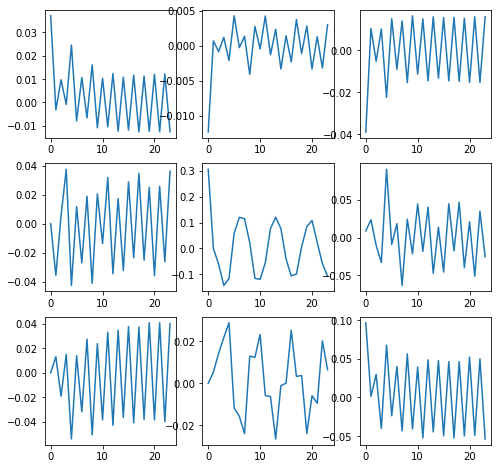

In [238]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(3,3,figsize=(8,8))
for col_i in range(3):
    for row_i in range(3):
        axes[row_i,col_i].plot(IR[:,row_i,col_i])

In [177]:
(B @ impulse).reshape(-1)#.shape


array([0.22631447, 0.        , 0.        ])

In [136]:
pd.DataFrame(VAR['F'])

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.058737,-0.013108,-0.021671,0.008820,0.004064,0.016150,-0.025125,-0.535886,-0.026883,0.043994,1.493355,0.038335,0.005006
1,0.946934,0.589290,0.192575,-0.040442,-1.576900,0.116281,0.020306,1.973971,0.053340,-0.133659,-1.146649,0.633180,0.157553
2,0.540648,0.550199,-0.025388,0.011557,-0.851549,-0.100893,0.339409,1.822491,0.226395,-0.367005,-1.641820,0.068130,0.946099


In [141]:
VAR['Fp'][:, :, 1]


array([[ 0.0040645 ,  0.0161504 , -0.02512535],
       [-1.57690026,  0.11628053,  0.02030631],
       [-0.8515494 , -0.1008926 ,  0.33940868]])

In [134]:
ii = 0
jj = 0

np.dot(PSI[:, :, ii - jj], VAR['Fp'][:, :, jj])

array([[-0.01310758, -0.0216707 ,  0.00882043],
       [ 0.58929039,  0.1925745 , -0.04044217],
       [ 0.55019894, -0.02538849,  0.01155709]])

In [124]:
PSI[:, :, ii - jj]

VAR['Fp'][:, :, jj]

array([[-0.01310758, -0.0216707 ,  0.00882043],
       [ 0.58929039,  0.1925745 , -0.04044217],
       [ 0.55019894, -0.02538849,  0.01155709]])

In [87]:
# def VARir(self, VARopt):
#         if not hasattr(self, 'results'):
#             raise ValueError('You need to fit the VAR model first')
        
#         IV = getattr(self, 'IV', None)
#         if VARopt['ident'] == 'iv' and IV is None:
#             raise ValueError('You need to provide the data for the instrument in VAR (IV)')
        
#         nsteps = VARopt['nsteps']
#         impact = VARopt['impact']
#         shut = VARopt['shut']
#         recurs = VARopt['recurs']
#         Fcomp = self.Fcomp
#         nvar = self.nvar
#         nlag = self.nlag
#         sigma = self.sigma
#         IR = np.full((nsteps, nvar, nvar), np.nan)

#         PSI = np.zeros((nvar, nvar, nsteps))
#         self.Fp = np.zeros((nvar, nvar, nlag))
#         I = self.const + 1
#         for ii in range(nsteps):
#             if ii < nlag:
#                 self.Fp[:, :, ii] = self.F[:, I:I + nvar]
#             else:
#                 self.Fp[:, :, ii] = np.zeros((nvar, nvar))
#             I += nvar

#         PSI[:, :, 0] = np.eye(nvar)
#         for ii in range(1, nsteps):
#             aux = np.zeros((nvar, nvar))
#             for jj in range(1, ii):
#                 aux += PSI[:, :, ii - jj] @ self.Fp[:, :, jj]
#             PSI[:, :, ii] = aux

#         self.PSI = PSI

#         if VARopt['ident'] == 'short':
#             try:
#                 B = cholesky(sigma, lower=True).T
#             except np.linalg.LinAlgError:
#                 raise ValueError('VCV is not positive definite')
#         elif VARopt['ident'] == 'long':
#             Finf_big = inv(np.eye(nvar) - Fcomp)
#             Finf = Finf_big[:nvar, :nvar]
#             D = cholesky(Finf @ sigma @ Finf.T).T
#             B = inv(Finf) @ D
#         elif VARopt['ident'] == 'sign':
#             if self.B is None:
#                 raise ValueError('You need to provide the B matrix with SR.m and/or SignRestrictions.m')
#             B = self.B
#         elif VARopt['ident'] == 'iv':
#             up = self.resid[:, 0]
#             uq = self.resid[:, 1:]
#             p, q, Z = self._prepare_iv_sample(up, uq, IV)
#             FirstStage = sm.OLS(p, Z).fit()
#             p_hat = FirstStage.fittedvalues
#             Biv = np.zeros((nvar, 1))
#             sqsp = np.zeros((uq.shape[1], 1))
#             for ii in range(1, nvar):
#                 SecondStage = sm.OLS(q[:, ii - 1], p_hat).fit()
#                 Biv[ii, 0] = SecondStage.params[1]
#                 sqsp[ii - 1] = SecondStage.params[1]
#             sigma_b = (1 / (p.shape[0] - self.ntotcoeff)) * (np.dot(pq - np.mean(pq, axis=0), (pq - np.mean(pq, axis=0)).T))
#             s21s11 = sqsp
#             S11 = sigma_b[0, 0]
#             S21 = sigma_b[1:, 0]
#             S22 = sigma_b[1:, 1:]
#             Q = np.outer(s21s11, s21s11) * S11 - (np.outer(S21, s21s11) + np.outer(s21s11, S21)) + S22
#             sp = np.sqrt(S11 - (S21 - s21s11 * S11) @ np.linalg.solve(Q, (S21 - s21s11 * S11)))
#             Biv = Biv * sp
#             B = np.zeros((nvar, nvar))
#             B[:, 0] = Biv.flatten()
#         else:
#             raise ValueError('Identification incorrectly specified. Choose one of the following options: short, long, sign, iv')

#         for mm in range(nvar):
#             if shut != 0:
#                 Fcomp[shut, :] = 0
#             response = np.zeros((nvar, nsteps))
#             impulse = np.zeros((nvar, 1))
#             if impact == 0:
#                 impulse[mm, 0] = 1
#             elif impact == 1:
#                 impulse[mm, 0] = 1 / B[mm, mm]
#             else:
#                 raise ValueError('Impact must be either 0 or 1')
#             response[:, 0] = B @ impulse
#             if shut != 0:
#                 response[shut, 0] = 0
#             if recurs == 'wold':
#                 for kk in range(1, nsteps):
#                     response[:, kk] = PSI[:, :, kk] @ B @ impulse
#             elif recurs == 'comp':
#                 for kk in range(1, nsteps):
#                     FcompN = np.linalg.matrix_power(Fcomp, kk - 1)
#                     response[:, kk] = FcompN[:nvar, :nvar] @ B @ impulse
#             IR[:, :, mm] = response.T

#         self.B = B
#         if VARopt['ident'] == 'iv':
#             self.FirstStage = FirstStage
#             self.sigma_b = sigma_b
#             self.Biv = Biv

#         return IR

1.2443553016100117

In [74]:
Fcomp = np.vstack([F[:, const:nvar * nlag + const], np.eye(nvar * (nlag - 1)), np.zeros((nvar * (nlag - 1), nvar))])

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 12 and the array at index 1 has size 9

In [76]:
nvar * (nlag - 1)

9

In [78]:
F

array([[ 0.05873746, -0.01310758, -0.0216707 ,  0.00882043,  0.0040645 ,
         0.0161504 , -0.02512535, -0.53588599, -0.02688314,  0.04399405,
         1.49335467,  0.03833482,  0.00500606],
       [ 0.94693354,  0.58929039,  0.1925745 , -0.04044217, -1.57690026,
         0.11628053,  0.02030631,  1.97397051,  0.05334   , -0.13365873,
        -1.14664903,  0.63318002,  0.15755302],
       [ 0.54064822,  0.55019894, -0.02538849,  0.01155709, -0.8515494 ,
        -0.1008926 ,  0.33940868,  1.82249108,  0.22639515, -0.36700459,
        -1.64181952,  0.06812969,  0.94609917]])

In [71]:
F[:, const:nvar * nlag + const].shape

(3, 12)

In [ ]:
'''
realgdp   - Real gross domestic product (Bil. of chained 2005 US$,
            seasonally adjusted annual rate)
realcons  - Real personal consumption expenditures (Bil. of chained
            2005 US$, seasonally adjusted annual rate)
realinv   - Real gross private domestic investment (Bil. of chained
            2005 US$, seasonally adjusted annual rate)
realgovt  - Real federal consumption expenditures & gross investment
            (Bil. of chained 2005 US$, seasonally adjusted annual rate)
realdpi   - Real private disposable income (Bil. of chained 2005
            US$, seasonally adjusted annual rate)
cpi       - End of the quarter consumer price index for all urban
            consumers: all items (1982-84 = 100, seasonally adjusted).
m1        - End of the quarter M1 nominal money stock (Seasonally
            adjusted)
tbilrate  - Quarterly monthly average of the monthly 3-month
            treasury bill: secondary market rate
unemp     - Seasonally adjusted unemployment rate (%)
pop       - End of the quarter total population: all ages incl. armed
            forces over seas
infl      - Inflation rate (ln(cpi_{t}/cpi_{t-1}) * 400)
realint   - Real interest rate (tbilrate - infl)
'''

In [20]:
mdata = sm.datasets.macrodata.load_pandas().data

dates = mdata[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]
quarterly = dates_from_str(quarterly)

mdata = mdata[['unemp','cpi','tbilrate']]
mdata.index = pd.DatetimeIndex(quarterly)
# data = np.log(mdata).diff().dropna()



<Axes: >

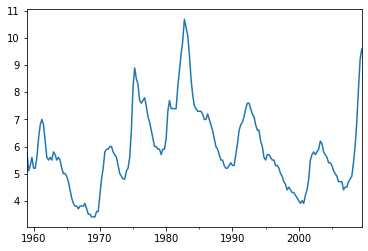

In [30]:
mdata.iloc[:,0].plot()
# np.log(mdata.iloc[:,1]).diff().plot()
# mdata.iloc[:,2].plot()

In [31]:
mdata

,unemp,cpi,tbilrate
1959-03-31,5.8,28.980,2.82
1959-06-30,5.1,29.150,3.08
1959-09-30,5.3,29.350,3.82
1959-12-31,5.6,29.370,4.33
1960-03-31,5.2,29.540,3.50
...,...,...,...
2008-09-30,6.0,216.889,1.17
2008-12-31,6.9,212.174,0.12
2009-03-31,8.1,212.671,0.22
2009-06-30,9.2,214.469,0.18


In [ ]:


def VARmodel(ENDO, nlag, const=0, EXOG=None, nlag_ex=0):
    # Check inputs
    nobs, nvar = ENDO.shape
    
    # Initialize VAR options
    VARopt = {'const': const, 'nlag': nlag, 'nlag_ex': nlag_ex}
    VAR = {'ENDO': ENDO, 'nlag': nlag, 'const': const}
    
    # Check for exogenous variables
    if EXOG is not None:
        nobs_ex, nvar_ex = EXOG.shape
        if nobs_ex != nobs:
            raise ValueError('nobs in EXOG-matrix not the same as y-matrix')
        VAR['EXOG'] = EXOG
    else:
        nvar_ex = 0
        VAR['EXOG'] = None
    
    # Save some parameters and create data matrices
    nobse = nobs - max(nlag, nlag_ex)
    VAR.update({
        'nobs': nobse,
        'nvar': nvar,
        'nvar_ex': nvar_ex,
        'nlag': nlag,
        'nlag_ex': nlag_ex,
        'ncoeff': nvar * nlag,
        'ntotcoeff': nvar * nlag + nvar_ex * (nlag_ex + 1) + const
    })
    
    # Create independent vector and lagged dependent matrix
    Y, X = VARmakexy(ENDO, nlag, const)
    
    # Create (lagged) exogenous matrix
    if nvar_ex > 0:
        X_EX = VARmakelags(EXOG, nlag_ex)
        if nlag == nlag_ex:
            X = np.hstack([X, X_EX])
        elif nlag > nlag_ex:
            diff = nlag - nlag_ex
            X_EX = X_EX[diff:, :]
            X = np.hstack([X, X_EX])
        elif nlag < nlag_ex:
            diff = nlag_ex - nlag
            Y = Y[diff:, :]
            X = np.hstack([X[diff:, :], X_EX])
    
    # OLS estimation equation by equation
    VAR['results'] = {}
    for j in range(nvar):
        Yvec = Y[:, j]
        model = sm.OLS(Yvec, X).fit()
        VAR['results'][f'eq{j+1}'] = {
            'beta': model.params,
            'tstat': model.tvalues,
            'bstd': model.bse,
            'tprob': model.pvalues,
            'resid': model.resid,
            'yhat': model.fittedvalues,
            'y': Yvec,
            'rsqr': model.rsquared,
            'rbar': model.rsquared_adj,
            'sige': model.scale,
            'dw': model.durbin_watson
        }
    
    # Compute the matrix of coefficients & VCV
    Ft = np.linalg.inv(X.T @ X) @ X.T @ Y
    VAR['Ft'] = Ft
    F = Ft.T
    SIGMA = (1 / (nobse - VAR['ntotcoeff'])) * ((Y - X @ Ft).T @ (Y - X @ Ft))
    VAR.update({
        'F': Ft.T,
        'sigma': SIGMA,
        'resid': Y - X @ Ft,
        'X': X,
        'Y': Y
    })
    
    if nvar_ex > 0:
        VAR['X_EX'] = X_EX
    
    # Companion matrix of F and max eigenvalue
    Fcomp = np.vstack([F[:, const:nvar * nlag + const], np.eye(nvar * (nlag - 1)), np.zeros((nvar * (nlag - 1), nvar))])
    VAR['Fcomp'] = Fcomp
    VAR['maxEig'] = np.max(np.abs(np.linalg.eigvals(Fcomp)))
    
    # Initialize other results
    VAR.update({
        'B': None,   # Structural impact matrix (need identification: see VARir/VARvd/VARhd)
        'Biv': None, # First columns of structural impact matrix (need "iv" identification: see VARir/VARvd/VARhd)
        'PSI': None, # Wold multipliers (computed only with VARir/VARvd/VARhd)
        'Fp': None,  # Recursive F by lag (useful to compute MA representation)
        'IV': None   # External instruments for identification
    })
    
    return VAR, VARopt

def VARmakexy(ENDO, nlag, const):
    # Function to create lagged dependent matrix and independent vector
    # Implementation needed
    pass

def VARmakelags(EXOG, nlag_ex):
    # Function to create lagged exogenous matrix
    # Implementation needed
    pass


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.linalg import cholesky, inv
from scipy.stats import t as t_dist

class VARModel:
    def __init__(self, ENDO, nlag, const=0, EXOG=None, nlag_ex=0):
        self.ENDO = ENDO
        self.nlag = nlag
        self.const = const
        self.EXOG = EXOG
        self.nlag_ex = nlag_ex
        self.fit()

    def fit(self):
        nobs, nvar = self.ENDO.shape
        if self.EXOG is not None:
            nobs_ex, nvar_ex = self.EXOG.shape
            if nobs_ex != nobs:
                raise ValueError('nobs in EXOG-matrix not the same as y-matrix')
        else:
            nvar_ex = 0

        nobse = nobs - max(self.nlag, self.nlag_ex)
        self.nobs = nobse
        self.nvar = nvar
        self.nvar_ex = nvar_ex
        self.ncoeff = nvar * self.nlag
        self.ntotcoeff = self.ncoeff + nvar_ex * (self.nlag_ex + 1) + self.const

        Y, X = self.VARmakexy(self.ENDO, self.nlag, self.const)
        
        if nvar_ex > 0:
            X_EX = self.VARmakelags(self.EXOG, self.nlag_ex)
            if self.nlag == self.nlag_ex:
                X = np.hstack([X, X_EX])
            elif self.nlag > self.nlag_ex:
                diff = self.nlag - self.nlag_ex
                X_EX = X_EX[diff:, :]
                X = np.hstack([X, X_EX])
            elif self.nlag < self.nlag_ex:
                diff = self.nlag_ex - self.nlag
                Y = Y[diff:, :]
                X = np.hstack([X[diff:, :], X_EX])

        # OLS estimation
        self.results = {}
        for j in range(nvar):
            Yvec = Y[:, j]
            model = sm.OLS(Yvec, X).fit()
            self.results[f'eq{j+1}'] = {
                'beta': model.params,
                'tstat': model.tvalues,
                'bstd': model.bse,
                'tprob': model.pvalues,
                'resid': model.resid,
                'yhat': model.fittedvalues,
                'y': Yvec,
                'rsqr': model.rsquared,
                'rbar': model.rsquared_adj,
                'sige': model.scale,
                'dw': model.durbin_watson
            }

        Ft = np.linalg.inv(X.T @ X) @ X.T @ Y
        self.Ft = Ft
        F = Ft.T
        SIGMA = (1 / (nobse - self.ntotcoeff)) * ((Y - X @ Ft).T @ (Y - X @ Ft))
        self.F = Ft.T
        self.sigma = SIGMA
        self.resid = Y - X @ Ft
        self.X = X
        self.Y = Y

        if nvar_ex > 0:
            self.X_EX = X_EX

        Fcomp = np.vstack([F[:, self.const:self.nvar * self.nlag + self.const], np.eye(nvar * (self.nlag - 1)), np.zeros((nvar * (self.nlag - 1), nvar))])
        self.Fcomp = Fcomp
        self.maxEig = np.max(np.abs(np.linalg.eigvals(Fcomp)))

        self.B = None
        self.Biv = None
        self.PSI = None
        self.Fp = None
        self.IV = None

    def VARmakexy(self, ENDO, nlag, const):
        # Placeholder for creating lagged dependent matrix and independent vector
        pass

    def VARmakelags(self, EXOG, nlag_ex):
        # Placeholder for creating lagged exogenous matrix
        pass

    def VARir(self, VARopt):
        # Check inputs
        if not hasattr(self, 'results'):
            raise ValueError('You need to fit the VAR model first')
        
        IV = getattr(self, 'IV', None)
        if VARopt['ident'] == 'iv' and IV is None:
            raise ValueError('You need to provide the data for the instrument in VAR (IV)')
        
        nsteps = VARopt['nsteps']
        impact = VARopt['impact']
        shut = VARopt['shut']
        recurs = VARopt['recurs']
        Fcomp = self.Fcomp
        nvar = self.nvar
        nlag = self.nlag
        sigma = self.sigma
        IR = np.full((nsteps, nvar, nvar), np.nan)

        # Compute Wold representation
        PSI = np.zeros((nvar, nvar, nsteps))
        self.Fp = np.zeros((nvar, nvar, nlag))
        I = self.const + 1
        for ii in range(nsteps):
            if ii < nlag:
                self.Fp[:, :, ii] = self.F[:, I:I + nvar]
            else:
                self.Fp[:, :, ii] = np.zeros((nvar, nvar))
            I += nvar

        PSI[:, :, 0] = np.eye(nvar)
        for ii in range(1, nsteps):
            aux = np.zeros((nvar, nvar))
            for jj in range(1, ii):
                aux += PSI[:, :, ii - jj] @ self.Fp[:, :, jj]
            PSI[:, :, ii] = aux

        self.PSI = PSI

        # Identification: Recover B matrix
        if VARopt['ident'] == 'short':
            try:
                B = cholesky(sigma, lower=True).T
            except np.linalg.LinAlgError:
                raise ValueError('VCV is not positive definite')
        elif VARopt['ident'] == 'long':
            Finf_big = inv(np.eye(nvar) - Fcomp)
            Finf = Finf_big[:nvar, :nvar]
            D = cholesky(Finf @ sigma @ Finf.T).T
            B = inv(Finf) @ D
        elif VARopt['ident'] == 'sign':
            if self.B is None:
                raise ValueError('You need to provide the B matrix with SR.m and/or SignRestrictions.m')
            B = self.B
        elif VARopt['ident'] == 'iv':
            up = self.resid[:, 0]
            uq = self.resid[:, 1:]
            p, q, Z = self._prepare_iv_sample(up, uq, IV)
            FirstStage = sm.OLS(p, Z).fit()
            p_hat = FirstStage.fittedvalues
            Biv = np.zeros((nvar, 1))
            sqsp = np.zeros((uq.shape[1], 1))
            for ii in range(1, nvar):
                SecondStage = sm.OLS(q[:, ii - 1], p_hat).fit()
                Biv[ii, 0] = SecondStage.params[1]
                sqsp[ii - 1] = SecondStage.params[1]
            sigma_b = (1 / (p.shape[0] - self.ntotcoeff)) * (np.dot(pq - np.mean(pq, axis=0), (pq - np.mean(pq, axis=0)).T))
            s21s11 = sqsp
            S11 = sigma_b[0, 0]
            S21 = sigma_b[1:, 0]
            S22 = sigma_b[1:, 1:]
            Q = np.outer(s21s11, s21s11) * S11 - (np.outer(S21, s21s11) + np.outer(s21s11, S21)) + S22
            sp = np.sqrt(S11 - np.dot(np.linalg.solve(Q, S21 - s21s11 * S11), (S21 - s21s11 * S11)))
            Biv = Biv * sp
            B = np.zeros((nvar, nvar))
            B[:, 0] = Biv.flatten()
        else:
            raise ValueError('Identification incorrectly specified. Choose from: short, long, sign, iv')

        # Compute the impulse response
        for mm in range(nvar):
            if shut != 0:
                Fcomp[shut, :] = 0
            response = np.zeros((nvar, nsteps))
            impulse = np.zeros(nvar)
            if impact == 0:
                impulse[mm] = 1
            elif impact == 1:
                impulse[mm] = 1 / B[mm, mm]
            else:
                raise ValueError('Impact must be either 0 or 1')
            response[:, 0] = B @ impulse
            if shut != 0:
                response[shut, 0] = 0
            if recurs == 'wold':
                for kk in range(1, nsteps):
                    response[:, kk] = PSI[:, :, kk] @ B @ impulse
            elif recurs == 'comp':
                for kk in range(1, nsteps):
                    FcompN = np.linalg.matrix_power(Fcomp, kk - 1)
                    response[:, kk] = FcompN[:nvar, :nvar] @ B @ impulse
            IR[:, :, mm] = response.T

        self.B = B
        if VARopt['ident'] == 'iv':
            self.FirstStage = FirstStage
            self.sigma_b = sigma_b
            self.Biv = Biv

        return IR

    def _prepare_iv_sample(self, up, uq, IV):
        # Helper function to prepare sample for IV
        from statsmodels.regression import linear_model as lm

        aux = np.hstack([up.reshape(-1, 1), IV[self.nlag:]])
        p = aux[:, 0]
        q = uq[-len(p):]
        Z = aux[:, 1:]

        return p, q, Z
